In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import *

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
train_files = glob.glob('./data/train/*.npy')
len(train_files)

62735

In [4]:
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)

In [5]:
full_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
full_dataset = full_dataset.batch(256).prefetch(1)

In [6]:
full_dataset

<PrefetchDataset shapes: ((None, 120, 120, 4), (None, 120, 120, 1)), types: (tf.float32, tf.float32)>

In [7]:
NUM_TRAIN = int(len(train_files)*.7)

full_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))

train_dataset = full_dataset.take(NUM_TRAIN)
train_dataset = train_dataset.batch(256).prefetch(1)
val_dataset = full_dataset.skip(NUM_TRAIN)
val_dataset = val_dataset.batch(256).prefetch(1)

In [8]:
full_dataset

<FlatMapDataset shapes: ((120, 120, 4), (120, 120, 1)), types: (tf.float32, tf.float32)>

In [9]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[42])

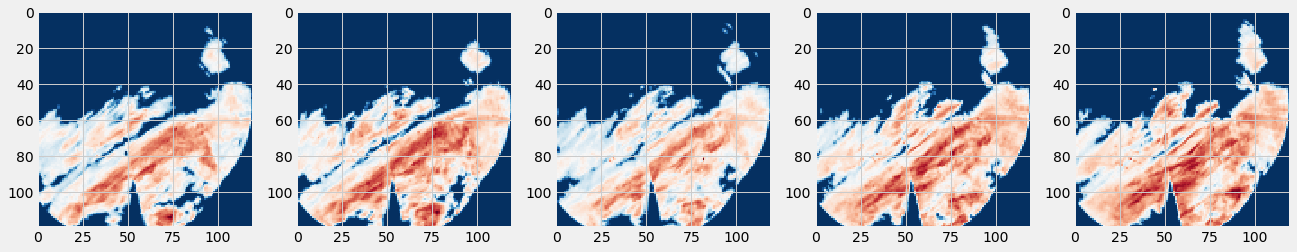

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [3]:
def base_model(input_layer, start_neurons):
    
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(pool1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(pool2)

    convm = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = layers.BatchNormalization()(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = layers.BatchNormalization()(uconv1)
    output_layer = layers.Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,64)

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/baseline_conv.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [13]:
model = Model(input_layer, output_layer)
model.compile(loss='mse', optimizer='adam')
model.fit(train_dataset, epochs = 50,
          callbacks = callbacks, validation_data=val_dataset,
          verbose=1)

Epoch 1/50
      2/Unknown - 1s 459ms/step - loss: 1554.0375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3161s vs `on_train_batch_end` time: 0.6000s). Check your callbacks.
    172/Unknown - 115s 669ms/step - loss: 833.2042
Epoch 00001: val_loss improved from inf to 320.84872, saving model to ./models/baseline_conv.h5
172/172 [==============================] - 172s 998ms/step - loss: 833.2042 - val_loss: 320.8487
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 467.5272
Epoch 00002: val_loss improved from 320.84872 to 165.74825, saving model to ./models/baseline_conv.h5
172/172 [==============================] - 166s 963ms/step - loss: 467.5272 - val_loss: 165.7482
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 326.9884
Epoch 00003: val_loss improved from 165.74825 to 164.73734, saving model to ./models/baseline_conv.h5
172/172 [==============================] - 147s 852ms/step - l

KeyboardInterrupt: 

In [5]:
best_model = model.load_weights('./models/baseline_conv.h5')

In [6]:
test_path = './data/test'
test_files = sorted(glob.glob(test_path + '/*.npy'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)

test: 100%|██████████| 2674/2674 [00:00<00:00, 3182.86it/s]


In [7]:
X_test.shape

(2674, 120, 120, 4)

In [8]:
pred = model.predict(X_test)

In [9]:
submission = pd.read_csv('./data/sample_submission.csv')

In [10]:
submission.iloc[:,1:] = pred.reshape(-1, 14400).astype(int)
submission.to_csv('./results/Dacon_baseline.csv', index = False)